# Computational-based 


In [1]:
# Load the Data

import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})


# clean_data = clean_data.drop(['ID','Subjectivity', 'Sentiment Polarity', 'Sarcasm', 'Irony', 'Negation'], axis=1)

clean_data.info()
clean_data.head()
clean_data.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 5072
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  1114 non-null   int64 
 1   Text                1114 non-null   object
 2   Subjectivity        1114 non-null   int64 
 3   Sentiment Polarity  1114 non-null   object
 4   Emotion             1114 non-null   object
 5   Sarcasm             1114 non-null   int64 
 6   Irony               1114 non-null   int64 
 7   Negation            1114 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 78.3+ KB


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
5068,20200659,"Wow growing together, so I will get a 17 black...",1,positive,disgust,0,1,0
5069,20200660,Equal pay for equal work to be introduced in t...,1,positive,anticipation,0,0,1
5070,20200661,No cash when worth more then 10000?. Use offsh...,1,negative,anticipation,0,1,0
5071,20200662,"Budget 2020 reactions: Some say it’s good, oth...",1,negative,anger,0,0,0
5072,20200663,"Budget 2020 reactions: Some say it’s good, oth...",1,neutral,sadness,0,0,0


In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
# Handle text processing and tokenisation:

import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer, AutoTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Raw_Text'] = processed_data['Text']

processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
tokenizer.model_max_length = 100
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (151 > 100). Running this sequence through the model will result in indexing errors


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,Raw_Text,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, ci, ##gare, ##tte, touch...","[101, 11838, 21455, 12818, 11200, 46511, 11993...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,I haven't exactly scanned the budget throughou...,"[exactly, sc, ##anne, ##d, budget, throughout,...","[101, 56938, 16427, 31570, 10163, 21455, 15410...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,There’s already smoking cessation programs for...,"[already, smoking, ces, ##sation, program, peo...","[101, 18874, 67503, 12139, 22337, 11660, 11227...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 31329, 26150, 13742, 23247, 47651, 22389...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 37872, 16497, 12047, 10228, 11913, 54838...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [26]:
# Count Punctuation

import re
import pandas as pd

def count_punctuation(text, tokens):
    exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    ellipsis_count = len(re.findall(r'\.\.\.', text))
    comma_count = len(re.findall(r',', text))
    period_count = len(re.findall(r'\. ', text))
    token_count = len(tokens)
    if token_count == 0:
        token_count = 1
    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'ellipsis_count': ellipsis_count,
        'comma_count': comma_count,
        'period_count': period_count,
        'exclamation_score': exclamation_count / token_count,
        'question_score': question_count / token_count,
        'ellipsis_score': ellipsis_count / token_count,
        'comma_score': comma_count / token_count,
        'period_score': period_count / token_count
    })

processed_data = processed_data.join(
    processed_data.apply(lambda row: count_punctuation(row['Raw_Text'], row['tokens']), axis=1)
)
    
print(processed_data)

            ID                                               Text  \
0     20180001  great budget even cigarette touched great work...   
1     20180002  exactly scanned budget throughout earth make i...   
2     20180003  already smoking cessation program people want ...   
3     20180004  alcohol fuel private vehicle raising tax cigar...   
4     20180005  practical say third world country supposed eur...   
...        ...                                                ...   
5068  20200659              wow growing together get black budget   
5069  20200660  equal pay equal work introduced private sector...   
5070  20200661                    cash worth use offshore account   
5071  20200662  budget reaction say good others say bad earnes...   
5072  20200663  budget reaction say good others say bad happen...   

      Subjectivity Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0                1           positive         trust        0      0         1   
1        

In [5]:
#getting Polarity. 
from tqdm import tqdm
from transformers import pipeline, AutoModelForSequenceClassification

# Load sentiment analysis pipeline
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def get_sentiment(tokens):
    total_score = 0
    result = sentiment_analyzer(tokens)
    if len(result) == 0:
        return 0.0
    for r in result:
        total_score += r['score']
    return total_score / len(result)

processed_data['polarity_score'] = processed_data['tokens'].apply(get_sentiment)

print(processed_data[['Text','Sentiment Polarity','polarity_score']].head())


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                                Text Sentiment Polarity  \
0  great budget even cigarette touched great work...           positive   
1  exactly scanned budget throughout earth make i...           negative   
2  already smoking cessation program people want ...            neutral   
3  alcohol fuel private vehicle raising tax cigar...           negative   
4  practical say third world country supposed eur...           negative   

   polarity_score  
0        0.344246  
1        0.355173  
2        0.327859  
3        0.337148  
4        0.353488  


In [6]:
#Subjectivity

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel
import torch
import logging

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and convert to BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

X = get_bert_embeddings(processed_data['Text'])
y = processed_data['Subjectivity']

# Train SVM classifier
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
clf.fit(X, y)

# Get the decision function values or probabilities
subjectivity_scores = clf.decision_function(X)
processed_data['Subjectivity Score'] = subjectivity_scores
print(processed_data[['Text', 'Subjectivity', 'Subjectivity Score']].head())

                                                Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

   Subjectivity Score  
0            1.255712  
1            1.519525  
2            1.655452  
3            1.761820  
4            1.326423  


In [7]:
# Sarcasm detection using BERT and LSTM
import torch
import torch.nn as nn


class SarcasmLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, num_layers):
        super(SarcasmLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        logits = self.fc(lstm_output[:, -1, :])
        return self.sigmoid(logits)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize the LSTM model
sarcasm_model = SarcasmLSTM(bert_model, hidden_dim=256, output_dim=1, num_layers=2)

# Tokenize and predict sarcasm for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    sarcasm_prob = sarcasm_model(inputs).numpy()

processed_data['Sarcasm Score'] = sarcasm_prob.flatten()  # Keep the raw probability

print(processed_data[['Text', 'Sarcasm', 'Sarcasm Score']].head())

                                                Text  Sarcasm  Sarcasm Score
0  great budget even cigarette touched great work...        0       0.513325
1  exactly scanned budget throughout earth make i...        0       0.508531
2  already smoking cessation program people want ...        0       0.508846
3  alcohol fuel private vehicle raising tax cigar...        0       0.503747
4  practical say third world country supposed eur...        0       0.507530


In [8]:
# Irony detection - not ready yet!!!!


from transformers import RobertaTokenizer, RobertaModel
import numpy as np

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

# Dummy lexicon-based feature function
def lexicon_features(text):
    irony_words = ['irony', 'sarcastic', 'contradict']
    count = sum(word in text.lower() for word in irony_words)
    return np.array([count])

# Combine RoBERTa embeddings with lexicon features
def get_combined_features(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    lexicon_feats = np.array([lexicon_features(text) for text in texts])
    return np.concatenate([embeddings, lexicon_feats], axis=1)

# Get combined features for the entire dataset
X = get_combined_features(processed_data['Text'])

# Fine-tuned irony detection model (replace with an actual model)
irony_classifier = pipeline('text-classification', model='cardiffnlp/twitter-roberta-base-irony')

# Predict irony
irony_predictions = processed_data['Text'].apply(lambda text: irony_classifier(text)[0])
processed_data['Irony Score'] = irony_predictions.apply(lambda x: x['score'])

print(processed_data[['Text', 'Irony', 'Irony Score']].head())

                                                Text  Irony  Irony Score
0  great budget even cigarette touched great work...      0     0.858841
1  exactly scanned budget throughout earth make i...      0     0.763247
2  already smoking cessation program people want ...      0     0.835225
3  alcohol fuel private vehicle raising tax cigar...      0     0.626248
4  practical say third world country supposed eur...      0     0.832839


In [11]:
# Negation detection
from torchcrf import CRF

class LSTM_CRF(nn.Module):
    def __init__(self, bert_model, hidden_dim, tagset_size):
        super(LSTM_CRF, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        emissions = self.hidden2tag(lstm_output)
        return emissions

    def predict(self, inputs):
        emissions = self(inputs)
        return self.crf.decode(emissions), emissions

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize the LSTM-CRF model
negation_model = LSTM_CRF(bert_model, hidden_dim=128, tagset_size=3)  # Assume 3 tags (e.g., "O", "NEG", "POS")

# Tokenize and predict negation for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)

negation_tags, negation_scores = negation_model.predict(inputs)

# Extract the highest score for negation tag for each sentence
processed_data['Negation Score'] = [torch.max(score[:, 1]).item() for score in negation_scores]  # Assuming index 1 is the "NEG" tag

print(processed_data[['Text', 'Negation', 'Negation Score']].head())


/opt/homebrew/lib/python3.11/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:530.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


                                                Text  Negation  Negation Score
0  great budget even cigarette touched great work...         1        0.215940
1  exactly scanned budget throughout earth make i...         1        0.198376
2  already smoking cessation program people want ...         0        0.155716
3  alcohol fuel private vehicle raising tax cigar...         0        0.199171
4  practical say third world country supposed eur...         1        0.181633


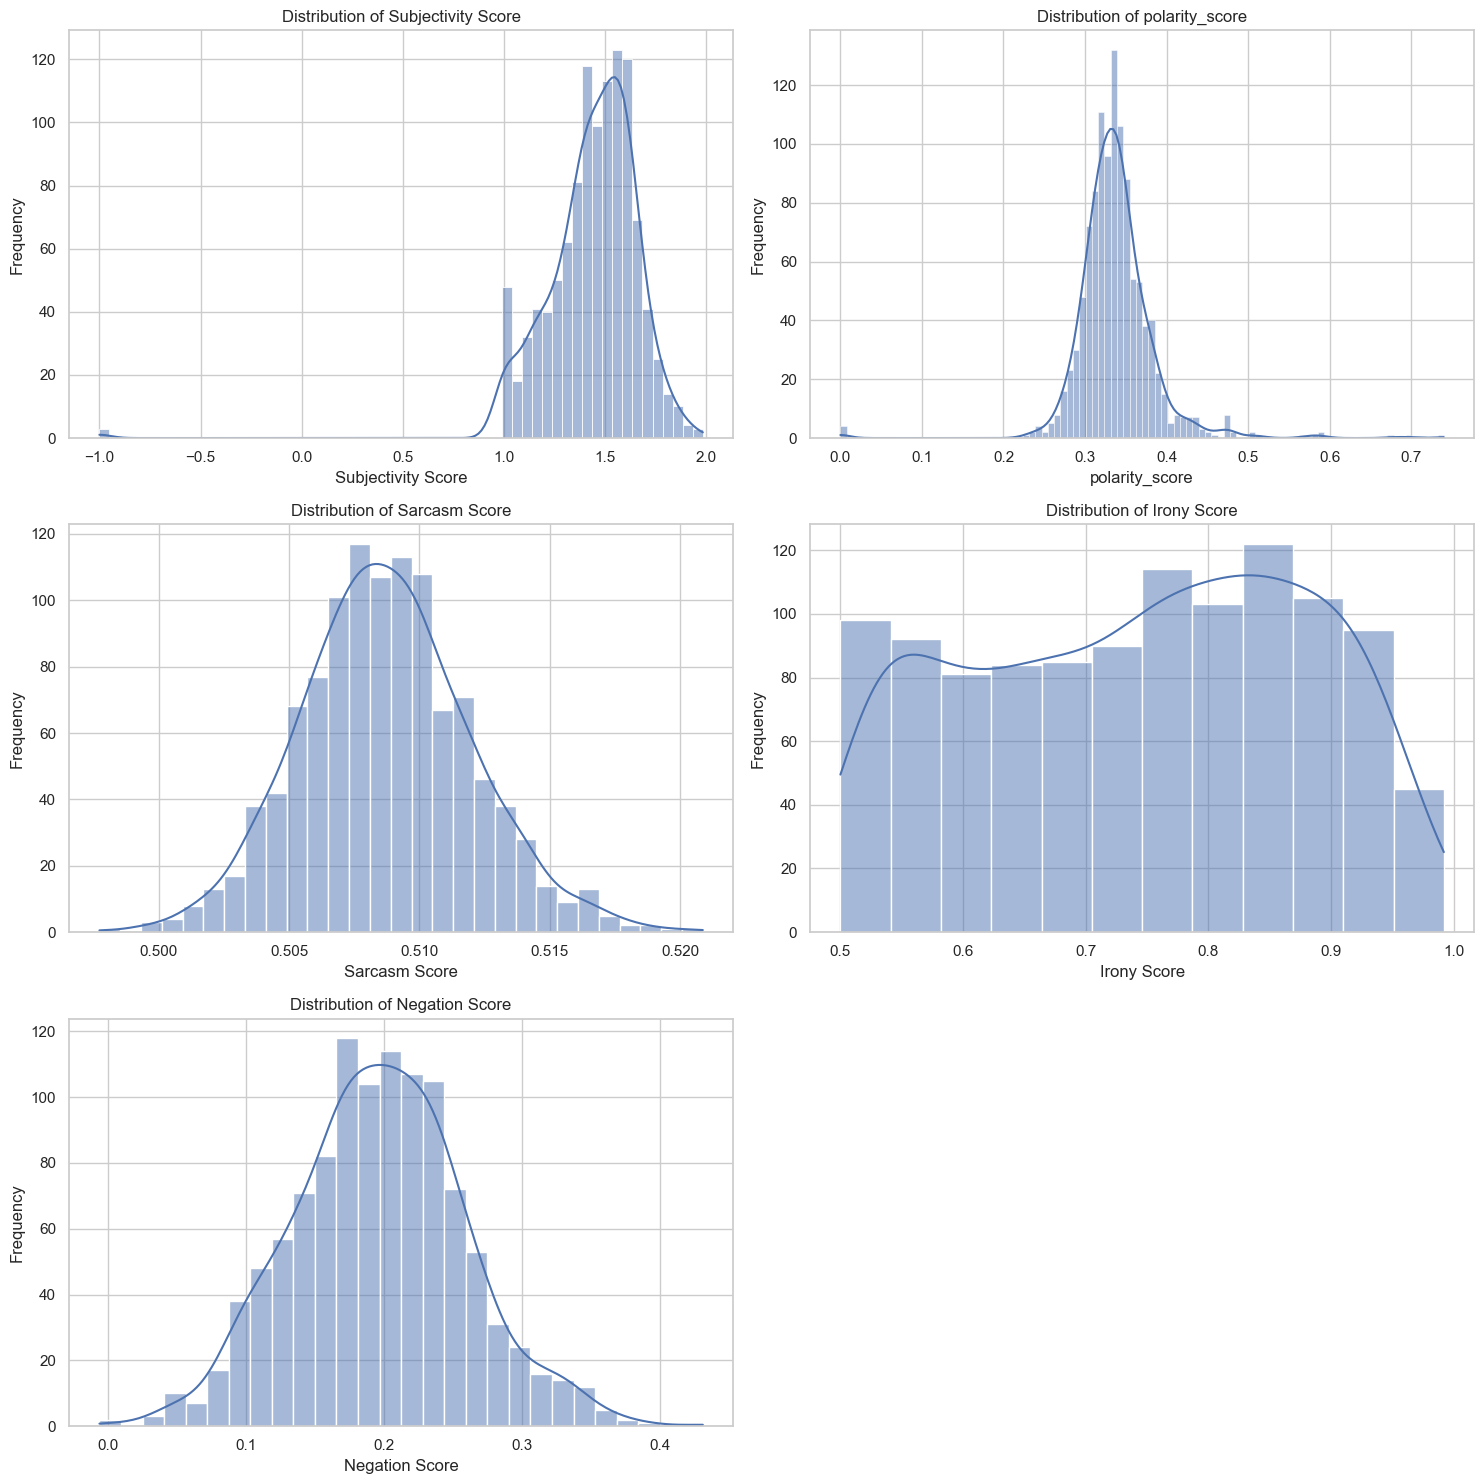

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set(style="whitegrid")

columns_to_plot = ['Subjectivity Score', 'polarity_score', 'Sarcasm Score', 'Irony Score', 'Negation Score']

# Set up the plot grid: 2 columns per row
num_cols = 2
num_rows = (len(columns_to_plot) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(columns_to_plot):
    sns.histplot(processed_data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots (in case of an odd number of plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show plot
plt.show()

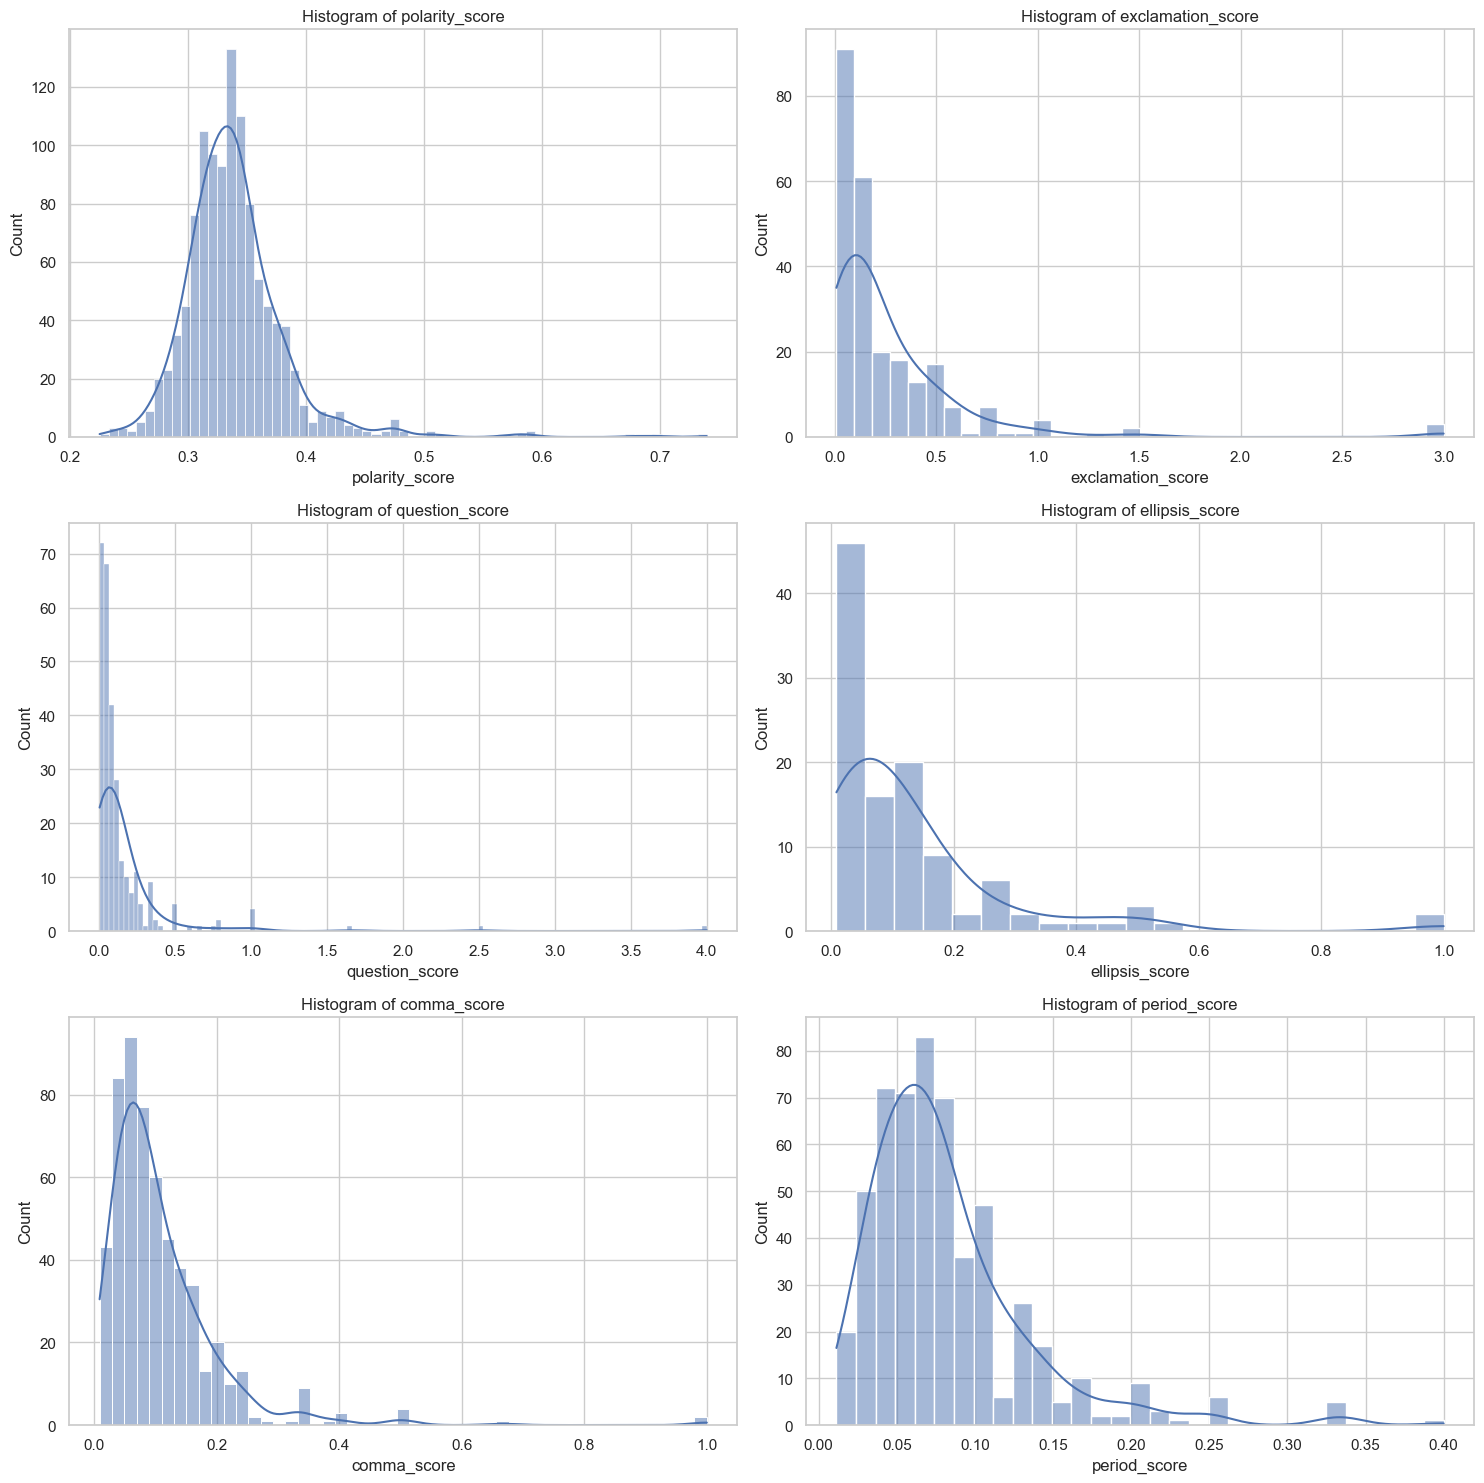

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

score_columns = [col for col in processed_data.columns if col.endswith('_score')]

# Step 2: Set up the grid layout
num_columns = 2  # Number of plots per row
num_plots = len(score_columns)
num_rows = (num_plots + num_columns - 1) // num_columns  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Step 3: Plot each histogram
for i, col in enumerate(score_columns):
    row = i // num_columns
    col_index = i % num_columns
    non_zero_data = processed_data[col][processed_data[col] != 0]
    #use processed_data[col] instead of non_zero_data
    sns.histplot(non_zero_data, kde=True, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'Histogram of {col}')

# If the number of plots is odd, remove the empty subplot
if num_plots % num_columns != 0:
    fig.delaxes(axes[num_rows-1, num_columns-1])

plt.tight_layout()
plt.show()

# FUZZY LOGIC SECTION

In [ ]:
# DO fuzzy logic here. 

In [27]:

processed_data.describe()

,ID,Subjectivity,Sarcasm,Irony,Negation,polarity_score,Subjectivity Score,Sarcasm Score,Irony Score,Negation Score,exclamation_count,question_count,ellipsis_count,comma_count,period_count,exclamation_score,question_score,ellipsis_score,comma_score,period_score
count,1.114000e+03,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,2.019173e+07,0.996409,0.088869,0.154399,0.316876,0.337950,1.441111,0.508694,0.742942,0.196358,0.651706,0.447935,0.194794,1.285458,1.043088,0.058809,0.039679,0.013002,0.053905,0.039767
std,8.108769e+03,0.059841,0.284682,0.361493,0.465468,0.048652,0.234749,0.003272,0.135490,0.062527,2.012285,1.073021,1.041256,2.121897,1.610816,0.216320,0.178929,0.065506,0.087226,0.054893
min,2.018000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000217,0.497719,0.500027,-0.006337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.018044e+07,1.000000,0.000000,0.000000,0.000000,0.314718,1.328700,0.506551,0.628374,0.155794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.019049e+07,1.000000,0.000000,0.000000,0.000000,0.334968,1.468698,0.508564,0.753331,0.196732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.020022e+07,1.000000,0.000000,0.000000,1.000000,0.355089,1.588527,0.510711,0.857862,0.237306,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.012271,0.000000,0.083333,0.067514
max,2.020066e+07,1.000000,1.000000,1.000000,1.000000,0.740043,1.984586,0.520874,0.991951,0.431026,24.000000,16.000000,24.000000,20.000000,18.000000,3.000000,4.000000,1.000000,1.000000,0.400000
